1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?  
-> 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.  

2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?  
-> tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다.  

3. Ablation Study 결과가 바른 포맷으로 제출되었는가?  
-> ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.  

## 1) ResNet 기본 블록 구성하기

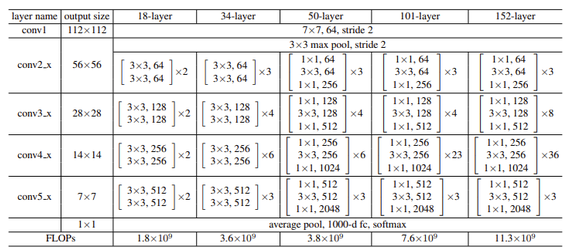

### 그래프 분석
1. conv1 - 7*7,64 채널 stride = 2 고정
2. conv2 - 3*3 max pool적용 후 stride = 2 고정 + residual_block 3번 반복 고정  
3. conv3~5- residual_block을 resnet layer에 따라서 다르게 적용  
4. output에 average pool적용 + softmax 함수 적용  

In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Dropout, Add, MaxPool2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense

def residual_block(input_layer, filters, stride = 1, resnet_layers = 34):

    # 50 이상부터는 위 아래로 커널 사이즈가 1인
    first_kernel_size = 3
    first_padding = 'same'
    last_filters = filters
    if resnet_layers > 34:
        first_kernel_size = 1
        first_padding = 'valid'
        last_filters = filters * 4 # 34 이상부터는 마지막 값이 *4

    x = Conv2D(filters, kernel_size=first_kernel_size, strides=stride, padding=first_padding)(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if resnet_layers > 34:
        x = Activation('relu')(x)
        x = Conv2D(last_filters, kernel_size=1, strides=1, padding='valid')(x)
        x = BatchNormalization()(x)

    # Residual connection
    shortcut = input_layer
    if stride > 1 or (resnet_layers > 34):
        shortcut = Conv2D(last_filters, 1, strides=stride, padding=first_padding)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

def build_resnet(input_shape, num_classes, resnet_layers=34, is_plain=False):

    # residual_block 반복 횟수 이론상 추가 가능하게 설계
    residual_layers_18  = [2, 2, 2, 2]
    residual_layers_34  = [3, 4, 6, 3]
    residual_layers_50  = [3, 4, 6, 3]

    # input에서 고를 수 있게 dic처리
    residual_layers = {18: residual_layers_18, 34:residual_layers_34, 50:residual_layers_50}

    # 이값은 고정
    channel_list = [64, 128, 256, 512]

    input_layer = Input(shape=input_shape)

    x = input_layer

    # conv1 에서는 7*7,64 채널 stride2 가 고정이다.
    x = Conv2D(64, 7, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # conv2 에서는 3*3 maxpool, stride2 로 시작하고 반복 횟수에 따라서 다르다. 18=2,34-3,50~152 = 3
    x = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(x) # 고정

    for i, v in enumerate(residual_layers[resnet_layers]): # i = 0은 conv2
      for j in range(v): # residual_block 반복 횟수
        # resnet_layers 이 친구랑 index값 사용해서 처리
        if i != 0 and j == 0: # conv2가 아니면서 첫 번째 residual_block일 경우
          x = residual_block(x, channel_list[i], 2, resnet_layers) # stride 2고정
        else:
          x = residual_block(x, channel_list[i], 1, resnet_layers) # 나머지는 1

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation="sigmoid")(x)

    return Model(
      inputs=input_layer,
      outputs=outputs
    )

### 2) ResNet-34, ResNet-50 Complete Model

In [ ]:
num_classe1 = 1
num_classe2 = 2

## ResNet34

In [2]:
resnet_34 = build_resnet(input_shape=(32, 32, 3), num_classes=1, resnet_layers = 34)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 16, 16, 64)           0         ['batch_normalization[0][0

## ResNet50

In [3]:
resnet_50 = build_resnet(input_shape=(32, 32, 3), num_classes=1, resnet_layers = 50)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_36 (Conv2D)          (None, 16, 16, 64)           9472      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_36 (Ba  (None, 16, 16, 64)           256       ['conv2d_36[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_33 (Activation)  (None, 16, 16, 64)           0         ['batch_normalization_36

## 3) 일반 네트워크(plain network) 만들기

In [4]:
def plainnet_block(input_layer, filters, stride = 1, resnet_layers = 34, is_plain=False):

    # 50 이상부터는 위 아래로 커널 사이즈가 1인
    first_kernel_size = 3
    first_padding = 'same'
    last_filters = filters
    if resnet_layers > 34:
        first_kernel_size = 1
        first_padding = 'valid'
        last_filters = filters * 4 # 34 이상부터는 마지막 값이 *4

    x = Conv2D(filters, kernel_size=first_kernel_size, strides=stride, padding=first_padding)(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if resnet_layers > 34:
        x = Activation('relu')(x)
        x = Conv2D(last_filters, kernel_size=1, strides=1, padding='valid')(x)
        x = BatchNormalization()(x)

    x = Activation('relu')(x)
    return x

def build_plainnet(input_shape, num_classes, resnet_layers=34, is_plain=False):

    # residual_block 반복 횟수 이론상 추가 가능하게 설계
    residual_layers_18  = [2, 2, 2, 2]
    residual_layers_34  = [3, 4, 6, 3]
    residual_layers_50  = [3, 4, 6, 3]

    # input에서 고를 수 있게 dic처리
    residual_layers = {18: residual_layers_18, 34:residual_layers_34, 50:residual_layers_50}

    # 이값은 고정
    channel_list = [64, 128, 256, 512]

    input_layer = Input(shape=input_shape)

    x = input_layer

    # conv1 에서는 7*7,64 채널 stride2 가 고정이다.
    x = Conv2D(64, 7, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # conv2 에서는 3*3 maxpool, stride2 로 시작하고 반복 횟수에 따라서 다르다. 18=2,34-3,50~152 = 3
    x = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(x) # 고정

    for i, v in enumerate(residual_layers[resnet_layers]): # i = 0은 conv2
      for j in range(v): # residual_block 반복 횟수
        # resnet_layers 이 친구랑 index값 사용해서 처리
        if i != 0 and j == 0: # conv2가 아니면서 첫 번째 residual_block일 경우
          x = plainnet_block(x, channel_list[i], 2, resnet_layers, is_plain) # stride 2고정
        else:
          x = plainnet_block(x, channel_list[i], 1, resnet_layers, is_plain) # 나머지는 1

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(
      inputs=input_layer,
      outputs=outputs
    )

## 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

### ResNet-34 vs Plain-34

In [5]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), num_classes=1, resnet_layers = 34)
resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_101 (Conv2D)         (None, 112, 112, 64)         9472      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_101 (B  (None, 112, 112, 64)         256       ['conv2d_101[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_82 (Activation)  (None, 112, 112, 64)         0         ['batch_normalization_10

In [6]:
plainnet_34 = build_plainnet(input_shape=(224, 224, 3), num_classes=1, resnet_layers = 34,)
plainnet_34.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_137 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_137 (B  (None, 112, 112, 64)      256       
 atchNormalization)                                              
                                                                 
 activation_115 (Activation  (None, 112, 112, 64)      0         
 )                                                               
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                           

### ResNet-50 vs Plain-50

In [7]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), num_classes=1, resnet_layers = 50)
resnet_50.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_170 (Conv2D)         (None, 112, 112, 64)         9472      ['input_5[0][0]']             
                                                                                                  
 batch_normalization_170 (B  (None, 112, 112, 64)         256       ['conv2d_170[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_148 (Activation  (None, 112, 112, 64)         0         ['batch_normalization_17

In [8]:
plainnet_50 = build_plainnet(input_shape=(224, 224, 3), num_classes=1, resnet_layers = 50)
plainnet_50.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_235 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_235 (B  (None, 112, 112, 64)      256       
 atchNormalization)                                              
                                                                 
 activation_197 (Activation  (None, 112, 112, 64)      0         
 )                                                               
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                           

In [9]:
import tensorflow_datasets as tfds

In [10]:
# 테스트를 위한 함수
def test_layers(layers):
    residual_layers_18  = [2, 2, 2, 2]
    residual_layers_34 = [3,4,6,3]
    residual_layers_50 = [3,4,6,3]
    residual_layers_101 = [3,4,23,3]
    residual_layers_152 = [3,8,36,3]

    # input에서 고를 수 있게 dic처리
    residual_layers = {18: residual_layers_18, 34:residual_layers_34, 50:residual_layers_50,101:residual_layers_101,152:residual_layers_152}
    print(residual_layers[layers])

    for i, v in enumerate(residual_layers[layers]):
      print(i, v)

In [11]:
test_layers(18)

[2, 2, 2, 2]
0 2
1 2
2 2
3 2


## 훈련할 데이터셋 로드 cat dog

In [24]:
import tensorflow as tf
import tensorflow_datasets as tfds

# cats_vs_dogs 데이터셋 로드
dataset_name = "cats_vs_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    name=dataset_name,
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

# 데이터 전처리 함수 정의 (이미지 크기 조정)
def preprocess(image, label):

    # 이미지 크기 설정
    new_height, new_width = 224, 224

    image = tf.image.resize(image, (new_height, new_width))  # new_height, new_width는 원하는 크기로 수정
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# 데이터 전처리 적용
ds_train = ds_train.map(preprocess).shuffle(1000)
ds_test = ds_test.map(preprocess)

# 데이터 확인
print(ds_info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, 

In [13]:
!pip install -U tensorflow-datasets

In [14]:
epochs = 15
batch_size = 64

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

loss1 = 'binary_crossentropy'

loss2 = 'sparse_categorical_crossentropy'

# ModelCheckpoint 콜백 설정
checkpoint_path = "model_checkpoint.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,  # 검증 성능이 좋아질 때만 저장
    monitor='val_loss',  # 어떤 지표를 기준으로 할지 지정
    mode='min',          # 'min' 또는 'max': 'min'이면 지정된 지표가 감소할 때 저장, 'max'면 증가할 때 저장
    verbose=1
)

# 얼리 스탑핑 콜백 생성
early_stop = EarlyStopping(monitor='val_loss', patience=10)

resnet_34.compile(optimizer='adam',
              loss=loss1,
              metrics=['accuracy'])
hist_resnet_34 = resnet_34.fit(ds_train.batch(batch_size), epochs=epochs, validation_data=ds_test.batch(batch_size), callbacks=[checkpoint_callback, early_stop])

Epoch 1/15
291/291 [==============================] - ETA: 0s - loss: 0.7080 - accuracy: 0.6143
Epoch 1: val_loss improved from inf to 0.75883, saving model to model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


291/291 [==============================] - 89s 189ms/step - loss: 0.7080 - accuracy: 0.6143 - val_loss: 0.7588 - val_accuracy: 0.5166
Epoch 2/15
291/291 [==============================] - ETA: 0s - loss: 0.5795 - accuracy: 0.6965
Epoch 2: val_loss did not improve from 0.75883
291/291 [==============================] - 55s 185ms/step - loss: 0.5795 - accuracy: 0.6965 - val_loss: 1.3593 - val_accuracy: 0.4620
Epoch 3/15
291/291 [==============================] - ETA: 0s - loss: 0.5102 - accuracy: 0.7521
Epoch 3: val_loss improved from 0.75883 to 0.70271, saving model to model_checkpoint.h5
291/291 [==============================] - 52s 169ms/step - loss: 0.5102 - accuracy: 0.7521 - val_loss: 0.7027 - val_accuracy: 0.6391
Epoch 4/15
291/291 [==============================] - ETA: 0s - loss: 0.4567 - accuracy: 0.7888
Epoch 4: val_loss improved from 0.70271 to 0.64894, saving model to model_checkpoint.h5
291/291 [==============================] - 48s 160ms/step - loss: 0.4567 - accuracy: 0.

In [16]:
checkpoint_path = "model_checkpoint2.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,  # 검증 성능이 좋아질 때만 저장
    monitor='val_loss',  # 어떤 지표를 기준으로 할지 지정
    mode='min',          # 'min' 또는 'max': 'min'이면 지정된 지표가 감소할 때 저장, 'max'면 증가할 때 저장
    verbose=1
)

# 얼리 스탑핑 콜백 생성
early_stop = EarlyStopping(monitor='val_loss', patience=10)

plainnet_34.compile(optimizer='adam',
              loss=loss1,
              metrics=['accuracy'])
hist_plainnet_34 = plainnet_34.fit(ds_train.batch(batch_size), epochs=epochs, validation_data=ds_test.batch(batch_size), callbacks=[checkpoint_callback, early_stop])

Epoch 1/15
291/291 [==============================] - ETA: 0s - loss: 0.7136 - accuracy: 0.4961
Epoch 1: val_loss improved from inf to 0.89812, saving model to model_checkpoint2.h5
291/291 [==============================] - 91s 189ms/step - loss: 0.7136 - accuracy: 0.4961 - val_loss: 0.8981 - val_accuracy: 0.5099
Epoch 2/15
291/291 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.4961
Epoch 2: val_loss improved from 0.89812 to 0.69297, saving model to model_checkpoint2.h5
291/291 [==============================] - 57s 190ms/step - loss: 0.6959 - accuracy: 0.4961 - val_loss: 0.6930 - val_accuracy: 0.5099
Epoch 3/15
291/291 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.4961
Epoch 3: val_loss did not improve from 0.69297
291/291 [==============================] - 49s 161ms/step - loss: 0.6918 - accuracy: 0.4961 - val_loss: 0.6962 - val_accuracy: 0.5099
Epoch 4/15
291/291 [==============================] - ETA: 0s - loss: 0.6893 - accuracy: 

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# ModelCheckpoint 콜백 설정
checkpoint_path = "model_checkpoint3.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,  # 검증 성능이 좋아질 때만 저장
    monitor='val_loss',  # 어떤 지표를 기준으로 할지 지정
    mode='min',          # 'min' 또는 'max': 'min'이면 지정된 지표가 감소할 때 저장, 'max'면 증가할 때 저장
    verbose=1
)

# 얼리 스탑핑 콜백 생성
early_stop = EarlyStopping(monitor='val_loss', patience=10)

resnet_50.compile(optimizer='adam',
              loss=loss1,
              metrics=['accuracy'])
hist_resnet_50 = resnet_50.fit(ds_train.batch(batch_size), epochs=epochs, validation_data=ds_test.batch(batch_size), callbacks=[checkpoint_callback, early_stop])

Epoch 1/15
291/291 [==============================] - ETA: 0s - loss: 0.6656 - accuracy: 0.6336
Epoch 1: val_loss improved from inf to 0.92433, saving model to model_checkpoint3.h5
291/291 [==============================] - 148s 362ms/step - loss: 0.6656 - accuracy: 0.6336 - val_loss: 0.9243 - val_accuracy: 0.4905
Epoch 2/15
291/291 [==============================] - ETA: 0s - loss: 0.5839 - accuracy: 0.6967
Epoch 2: val_loss did not improve from 0.92433
291/291 [==============================] - 98s 331ms/step - loss: 0.5839 - accuracy: 0.6967 - val_loss: 1.2182 - val_accuracy: 0.6184
Epoch 3/15
291/291 [==============================] - ETA: 0s - loss: 0.5096 - accuracy: 0.7530
Epoch 3: val_loss did not improve from 0.92433
291/291 [==============================] - 98s 331ms/step - loss: 0.5096 - accuracy: 0.7530 - val_loss: 2.0086 - val_accuracy: 0.5757
Epoch 4/15
291/291 [==============================] - ETA: 0s - loss: 0.4469 - accuracy: 0.7932
Epoch 4: val_loss did not improve 

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# ModelCheckpoint 콜백 설정
checkpoint_path = "model_checkpoint4.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,  # 검증 성능이 좋아질 때만 저장
    monitor='val_loss',  # 어떤 지표를 기준으로 할지 지정
    mode='min',          # 'min' 또는 'max': 'min'이면 지정된 지표가 감소할 때 저장, 'max'면 증가할 때 저장
    verbose=1
)

# 얼리 스탑핑 콜백 생성
early_stop = EarlyStopping(monitor='val_loss', patience=10)

plainnet_50.compile(optimizer='adam',
              loss=loss1,
              metrics=['accuracy'])
hist_plainnet_50 = plainnet_50.fit(ds_train.batch(batch_size), epochs=epochs, validation_data=ds_test.batch(batch_size), callbacks=[checkpoint_callback, early_stop])

Epoch 1/15
291/291 [==============================] - ETA: 0s - loss: 0.7003 - accuracy: 0.4961
Epoch 1: val_loss improved from inf to 0.79276, saving model to model_checkpoint4.h5
291/291 [==============================] - 99s 245ms/step - loss: 0.7003 - accuracy: 0.4961 - val_loss: 0.7928 - val_accuracy: 0.5099
Epoch 2/15
291/291 [==============================] - ETA: 0s - loss: 0.6422 - accuracy: 0.4961
Epoch 2: val_loss did not improve from 0.79276
291/291 [==============================] - 65s 216ms/step - loss: 0.6422 - accuracy: 0.4961 - val_loss: 0.8392 - val_accuracy: 0.5099
Epoch 3/15
291/291 [==============================] - ETA: 0s - loss: 0.6010 - accuracy: 0.4961
Epoch 3: val_loss improved from 0.79276 to 0.71432, saving model to model_checkpoint4.h5
291/291 [==============================] - 65s 219ms/step - loss: 0.6010 - accuracy: 0.4961 - val_loss: 0.7143 - val_accuracy: 0.5099
Epoch 4/15
291/291 [==============================] - ETA: 0s - loss: 0.5769 - accuracy: 

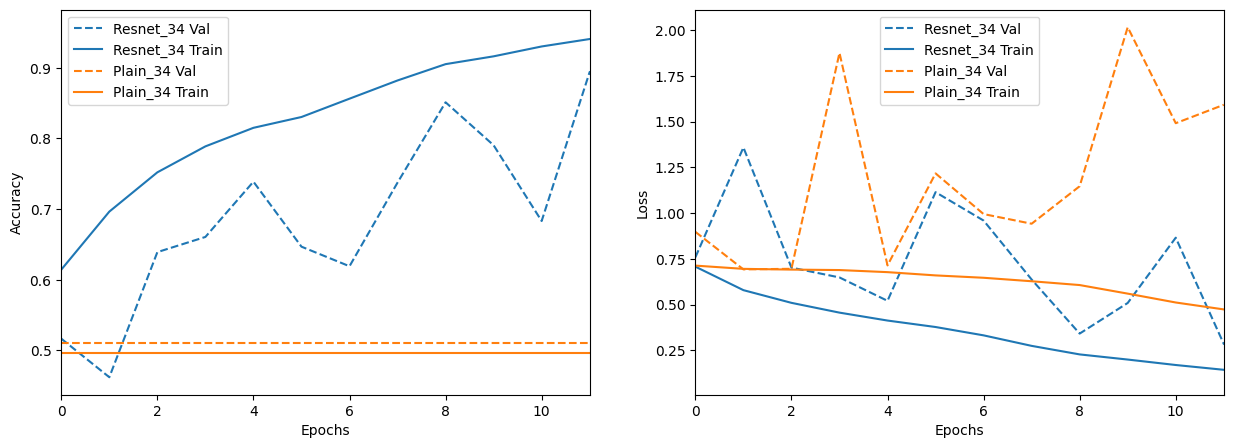

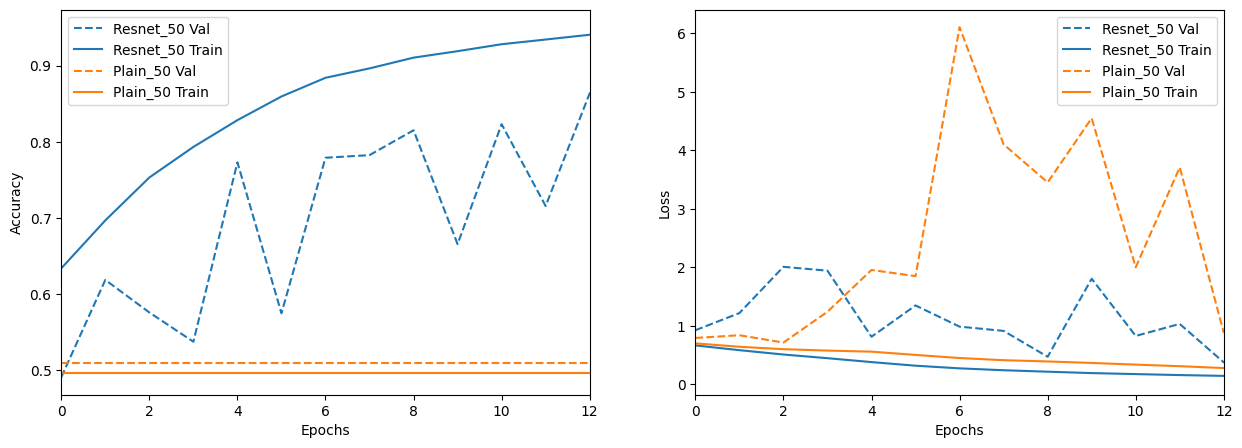

In [19]:
# 그래프 비교!
import matplotlib.pyplot as plt

def plot_history(histories, keys=('accuracy', 'loss')):
    plt.figure(figsize=(15, 5))

    for idx, key in enumerate(keys):
        plt.subplot(1, len(keys), idx + 1)

        for name, history in histories:
            val = plt.plot(history.epoch, history.history['val_' + key],
                           '--', label=name.title() + ' Val')
            plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                     label=name.title() + ' Train')

        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_', ' ').title())
        plt.legend()
        plt.xlim([0, max(history.epoch)])

plot_history([('resnet_34', hist_resnet_34),
              ('plain_34', hist_plainnet_34)])

plot_history([('resnet_50', hist_resnet_50),
              ('plain_50', hist_plainnet_50)])

## 결과
resnet34, resnet50의 결과를 보면 epoch이 진행되는 동안 accuracy는 높아지고 loss는 낮아지는게 보인다. val_accuracy로 비교해 봤을 때는 resnet_34 모델이 조금 더 높은 것을 볼 수 있는데 50이상부터 추가되는 앞 뒤의 레이어가 영향을 주는 것이 아닐까 라는 생각을 해볼 수 있었다.

## 회고
우선 주어진 그래프를 보고 resnet모델을 만들었는데 변수로 18layer에서 152layer까지 생성이 가능하게 만들어 보았다. 시간이 된다면 18~152까지 다 돌려보고 비교를 해봐야겠다.

너무 그래프만 보고 만들었더니 처음에 short cut을 더해주는 과정을 빼먹어서 accuracy가 낮게 계속 나오고 있었는데 뭔가 이상해서 돌려보던 중 알게 되어 추가했더니 나름 우상향 하는 그래프가 나와서 뿌듯했다.